In [ ]:
import ace_tools_open as tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time
from utils import (generate_gaussian_A, 
                   generate_t_distribution_A, 
                   compute_matrices, 
                   compute_left_singular_vectors,
                   compute_sampling_probabilities,
                   compute_sample_approximation_errors,
                   plot_probability_distribution,
                   plot_errors,
                   compute_projection_approximation_errors,
                   run_sample_trials, 
                   compute_mean_std, 
                   plot_error_with_variability,
                   run_projection_trials,
                    generate_random_projection_matrix, 
                    least_squares_projection,
                    run_ls_projection_trials
                   )

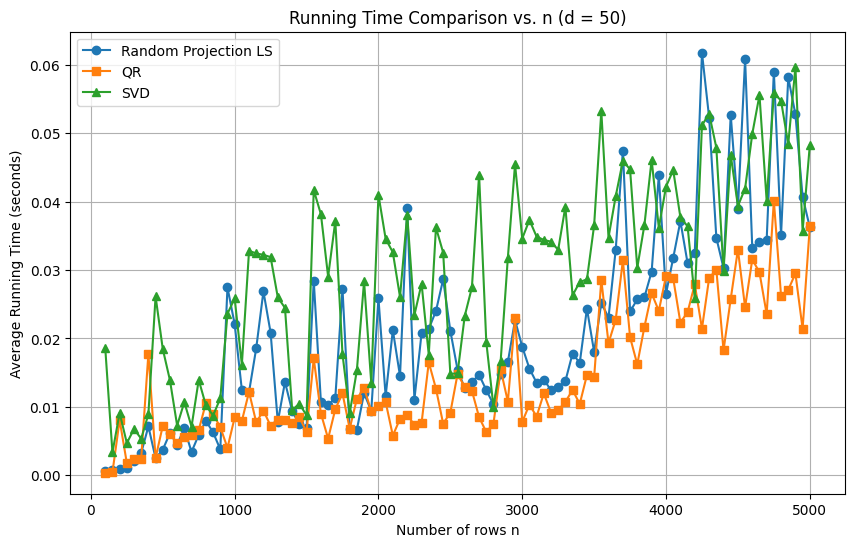

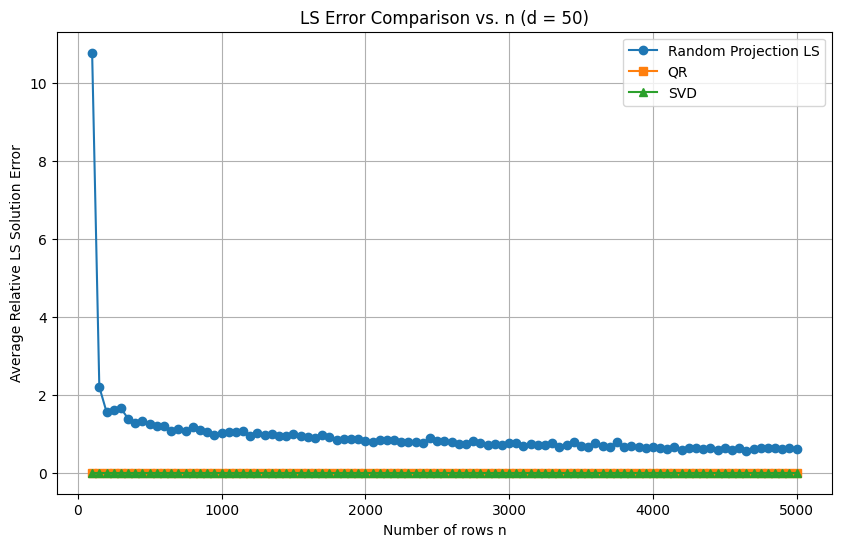

In [ ]:
# ----------------------------
# Parameters
# ----------------------------
d = 50                                  # fixed number of columns
n_list = list(range(2*d, 100*d+1, d))   # n from 2d to 100d, in steps of d
num_trials = 5                          # number of trials for averaging timings
oversampling_parameter = 0.5            # relative oversampling: r = oversampling_parameter * n
proj_method = 'sign'                    # use {±1} projection (dense)
sparsity = 0                            # dense projection matrix (sparsity=0)
seed = 1234

# ----------------------------
# Utility functions (assumed implemented)
# ----------------------------
# generate_gaussian_A(n, d, seed): returns an (n x d) dense Gaussian matrix.
# generate_random_projection_matrix(orig_dim, proj_dim, sparsity, method, seed):
#     returns a matrix of shape (orig_dim x proj_dim) with i.i.d. entries of the given type.
# least_squares_projection(A, b, P):
#     uses projection matrix P to compute an approximate LS solution.
#
# For this example, we assume that least_squares_projection performs:
#   x_approx = argmin_x || P^T A x - P^T b ||_2
# so that if A is (n x d) and P is (n x r), then P^T A is (r x d) and P^T b is (r,).

# ----------------------------
# Running time and error comparisons
# ----------------------------
time_rproj = []   # average running time of random projection method
time_qr = []      # average running time of QR method
time_svd = []     # average running time of SVD method

err_rproj = []    # average relative LS error for random projection method
err_qr = []       # average relative LS error for QR method
err_svd = []      # average relative LS error for SVD method

for n in n_list:
    t_rproj = []
    t_qr = []
    t_svd = []
    e_rproj = []
    e_qr = []
    e_svd = []
    
    for trial in range(num_trials):
        trial_seed = seed + trial
        
        # Generate an (n x d) matrix A and vector b (length n)
        A = generate_gaussian_A(n, d, seed=trial_seed)
        rng = np.random.default_rng(trial_seed)
        b = rng.random(n)
        
        # Compute true LS solution using full data
        x_true = np.linalg.lstsq(A, b, rcond=None)[0]
        
        # 1. Random Projection LS method:
        # Determine r = oversampling_parameter * n (as an integer)
        r = int(oversampling_parameter * n)
        # Generate a random projection matrix P of size (n x r) using {±1} entries.
        P = generate_random_projection_matrix(r, n, sparsity=sparsity, method=proj_method, seed=trial_seed)
        start = time.time()
        x_rproj = least_squares_projection(A, b, P)
        t_rproj.append(time.time() - start)
        e_rproj.append(np.linalg.norm(x_rproj - x_true) / np.linalg.norm(x_true))
        
        # 2. QR-based LS method:
        start = time.time()
        Q, R_mat = np.linalg.qr(A)
        x_qr = np.linalg.solve(R_mat, Q.T @ b)
        t_qr.append(time.time() - start)
        e_qr.append(np.linalg.norm(x_qr - x_true) / np.linalg.norm(x_true))
        
        # 3. SVD-based LS method:
        start = time.time()
        U, s_vals, Vt = np.linalg.svd(A, full_matrices=False)
        x_svd = Vt.T @ np.linalg.solve(np.diag(s_vals), U.T @ b)
        t_svd.append(time.time() - start)
        e_svd.append(np.linalg.norm(x_svd - x_true) / np.linalg.norm(x_true))
        
    time_rproj.append(np.mean(t_rproj))
    time_qr.append(np.mean(t_qr))
    time_svd.append(np.mean(t_svd))
    err_rproj.append(np.mean(e_rproj))
    err_qr.append(np.mean(e_qr))
    err_svd.append(np.mean(e_svd))

# ----------------------------
# Plot Running Times vs n
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(n_list, time_rproj, marker='o', label="Random Projection LS")
plt.plot(n_list, time_qr, marker='s', label="QR")
plt.plot(n_list, time_svd, marker='^', label="SVD")
plt.xlabel("Number of rows n")
plt.ylabel("Average Running Time (seconds)")
plt.title("Running Time Comparison vs. n (d = {})".format(d))
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# Plot LS Errors vs n (optional)
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(n_list, err_rproj, marker='o', label="Random Projection LS")
plt.plot(n_list, err_qr, marker='s', label="QR")
plt.plot(n_list, err_svd, marker='^', label="SVD")
plt.xlabel("Number of rows n")
plt.ylabel("Average Relative LS Solution Error")
plt.title("LS Error Comparison vs. n (d = {})".format(d))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ----------------------------
# Parameters
# ----------------------------
d = 500                                  # fixed number of columns
n_list = list(range(2*d, 100*d+1, d))   # n from 2d to 100d, in steps of d
num_trials = 5                          # number of trials for averaging timings
oversampling_parameter = 0.5            # relative oversampling: r = oversampling_parameter * n
proj_method = 'sign'                    # use {±1} projection (dense)
sparsity = 0                            # dense projection matrix (sparsity=0)
seed = 1234

# ----------------------------
# Utility functions (assumed implemented)
# ----------------------------
# generate_gaussian_A(n, d, seed): returns an (n x d) dense Gaussian matrix.
# generate_random_projection_matrix(orig_dim, proj_dim, sparsity, method, seed):
#     returns a matrix of shape (orig_dim x proj_dim) with i.i.d. entries of the given type.
# least_squares_projection(A, b, P):
#     uses projection matrix P to compute an approximate LS solution.
#
# For this example, we assume that least_squares_projection performs:
#   x_approx = argmin_x || P^T A x - P^T b ||_2
# so that if A is (n x d) and P is (n x r), then P^T A is (r x d) and P^T b is (r,).

# ----------------------------
# Running time and error comparisons
# ----------------------------
time_rproj = []   # average running time of random projection method
time_qr = []      # average running time of QR method
time_svd = []     # average running time of SVD method

err_rproj = []    # average relative LS error for random projection method
err_qr = []       # average relative LS error for QR method
err_svd = []      # average relative LS error for SVD method

for n in n_list:
    t_rproj = []
    t_qr = []
    t_svd = []
    e_rproj = []
    e_qr = []
    e_svd = []
    
    for trial in range(num_trials):
        trial_seed = seed + trial
        
        # Generate an (n x d) matrix A and vector b (length n)
        A = generate_gaussian_A(n, d, seed=trial_seed)
        rng = np.random.default_rng(trial_seed)
        b = rng.random(n)
        
        # Compute true LS solution using full data
        x_true = np.linalg.lstsq(A, b, rcond=None)[0]
        
        # 1. Random Projection LS method:
        # Determine r = oversampling_parameter * n (as an integer)
        r = int(oversampling_parameter * n)
        # Generate a random projection matrix P of size (n x r) using {±1} entries.
        P = generate_random_projection_matrix(r, n, sparsity=sparsity, method=proj_method, seed=trial_seed)
        start = time.time()
        x_rproj = least_squares_projection(A, b, P)
        t_rproj.append(time.time() - start)
        e_rproj.append(np.linalg.norm(x_rproj - x_true) / np.linalg.norm(x_true))
        
        # 2. QR-based LS method:
        start = time.time()
        Q, R_mat = np.linalg.qr(A)
        x_qr = np.linalg.solve(R_mat, Q.T @ b)
        t_qr.append(time.time() - start)
        e_qr.append(np.linalg.norm(x_qr - x_true) / np.linalg.norm(x_true))
        
        # 3. SVD-based LS method:
        start = time.time()
        U, s_vals, Vt = np.linalg.svd(A, full_matrices=False)
        x_svd = Vt.T @ np.linalg.solve(np.diag(s_vals), U.T @ b)
        t_svd.append(time.time() - start)
        e_svd.append(np.linalg.norm(x_svd - x_true) / np.linalg.norm(x_true))
        
    time_rproj.append(np.mean(t_rproj))
    time_qr.append(np.mean(t_qr))
    time_svd.append(np.mean(t_svd))
    err_rproj.append(np.mean(e_rproj))
    err_qr.append(np.mean(e_qr))
    err_svd.append(np.mean(e_svd))

# ----------------------------
# Plot Running Times vs n
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(n_list, time_rproj, marker='o', label="Random Projection LS")
plt.plot(n_list, time_qr, marker='s', label="QR")
plt.plot(n_list, time_svd, marker='^', label="SVD")
plt.xlabel("Number of rows n")
plt.ylabel("Average Running Time (seconds)")
plt.title("Running Time Comparison vs. n (d = {})".format(d))
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# Plot LS Errors vs n (optional)
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(n_list, err_rproj, marker='o', label="Random Projection LS")
plt.plot(n_list, err_qr, marker='s', label="QR")
plt.plot(n_list, err_svd, marker='^', label="SVD")
plt.xlabel("Number of rows n")
plt.ylabel("Average Relative LS Solution Error")
plt.title("LS Error Comparison vs. n (d = {})".format(d))
plt.legend()
plt.grid(True)
plt.show()